## Разминка: Давайте построим графики функций активаций и графики их производных.




Для того что бы построить сами функции аквтиваций можно воспользоваться готовыми функциями отсюда (https://pytorch.org/docs/master/nn.html#non-linear-activation-functions). Аля того что бы построить их производные можно использовать функционал pytorch вот тут: (https://pytorch.org/docs/stable/autograd.html).

Так же можно построить все своими руками.
   
Функции на которые мы посмотрим: `ReLU`, `ELU` ($\alpha = 1$), `Softplus` ($\beta = 1$) and `Sign`, `Sigmoid`, `Softsign`, `Tanh`.


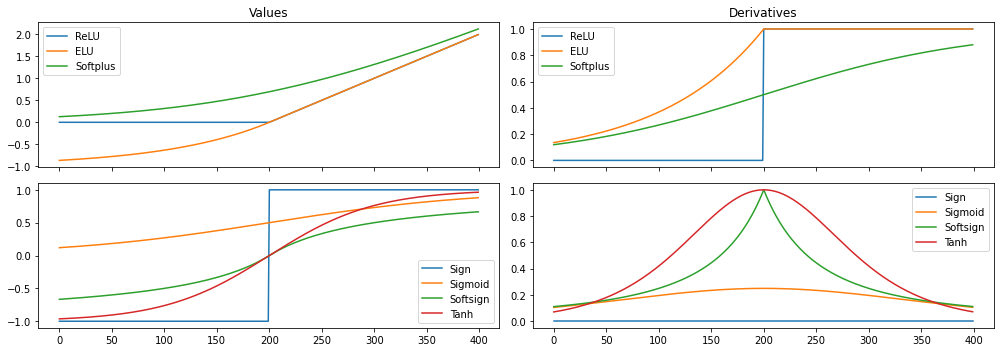

In [ ]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

x = torch.arange(-2, 2, .01, requires_grad=True)
x_np = x.detach().numpy()
x.sum().backward() # to create x.grad

f, axes = plt.subplots(2, 2, sharex=True, figsize=(14, 5))
axes[0, 0].set_title('Values')
axes[0, 1].set_title('Derivatives')

names = []

for i, function_set in (0, (('ReLU', F.relu), ('ELU', F.elu), ('Softplus', F.softplus))), \
                       (1, (('Sign', torch.sign), ('Sigmoid', torch.sigmoid), ('Softsign', F.softsign), ('Tanh', torch.tanh))):
    for function_name, activation in function_set:
        ### BEGIN Solution

        names.append(function_name)
        f = activation(x)

        # zero gradients otherwise they will add up
        x.grad = torch.zeros_like(x)

        f.sum().backward()
        d = x.grad

        axes[i, 0].plot(f.data, label=function_name)
        axes[i,1].plot(d.data, label=function_name)

        ### END Solution

    axes[i, 0].legend()
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

### Датасет

Загрузим датасет который будем классифицировать

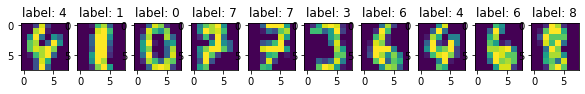

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# fetch the dataset.
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]
test_size = digits_test.shape[0]

input_size = 8*8
classes_n = 10


N = 10

sample_idx = np.random.choice(1797, N, replace=False)
digits_sample = digits[sample_idx]
targets_sample = targets[sample_idx]
f, ax  = plt.subplots(1,10, figsize=(10, 5))

for i in range(N):
    ax[i].imshow(digits_sample[i].reshape(8,8))
    ax[i].set_title('label: '+str(targets_sample[i]))

## I. Вспомним что нам нужно для того что бы найти параметры модели для бинарной классификации.


Для начала вспомним некоторые функции.
$$
sigmoid(x) = \frac{1}{1-e^{(-x)}}
$$
Эта функция изменяется от 0 до 1 и нам удобно ее использовать как на выходе модели потому что так мы можем расценивать выход модели как вероятности предсказаний. Но в данном случае мы будем использовать что бы добавить нелинейность между слоями модели.

Для выходного слоя мы будем использовать другую функцию Softmax, которая тоже изменяется от 0 до - 1.

Для начала вспомним некоторые функции.
$$
Softmax(z)_i = \frac{e^{z_i}}{\sum^{K}_{j=1}{{e^{(z_j)}}}}
$$

Чаще всего $z$ это вектор длинной разерностью $K$.

Для отпимизации модели мы будем использовать метод стохастического градиентного спуска - SGD.

<hr>

Для использования этого метода нам нужна некоторая функция потерь.

$P(наблюдаемые \space данные | W,B)$

$w = \underset{w,b}{argmax} P(Y,X|W) \\
 = \underset{w}{argmax} \prod^{n}_{i=1} P(y_i,x_i|W) = \\
 = \underset{w}{argmax} \prod^{n}_{i=1} P(y_i|x_i,W)P(x_i|W) = \\
 = \underset{w}{argmax} \prod^{n}_{i=1} P(y_i|x_i,W)P(x_i) =\\
 = \underset{w}{argmax} \prod^{n}_{i=1} P(y_i|x_i,W)
 $

Для бинарного случая мы получим следущее выражение:

$ w = \underset{w}{argmax} \prod^{n}_{i=1} P(y_i|x_i,W)= \\ \underset{w}{argmax} \prod^{n}_{i=1} F(x_i)^{y_i}(1-F(x_i))^{(1-y_i)}\\
$

В данном случае $y_i$ принимает значения 0 и 1. Если мы прологорифмируем это выражение, то задача максимизации по $W,B$ не поменяется, но будет численно более стабильной.

$W = \underset{w}{min} -\frac{1}{n}\sum^{n}_{i=1} y_ilog(F(x_i,W))+(1-F(x_i,W))(1-y_i)$

Так же поменяем знак и будем минимизировать эту функцию. Обозначим выражиение выше как $l(W)$ и найдем миними $l(W)$ по $W$ c помощью градиентного спуска.

$L(w) = -\frac{1}{n}\sum^{n}_{i=1} y_ilog(F(x_i,W))+(1-F(x_i,W))(1-y_i)$


В случае не бинарной, а многоклассовой классификации мы можем записать:

$L(w) = -\frac{1}{n}\sum^{n}_{i=1} P(x_i)log(F(x_i,W))$

Так как в нашем случае один объект принадлежит только к одному классу мы можем переписать выражение выше следующим образом:

$ CrossEntropyLoss(w) = -\frac{1}{n}\sum^{n}_{i=1} \mathbb{1}_\hat{y}log(F(x_i,W))$, где $\hat{y}$ это реальный класс объекта, а $F(x_i)$ предсказания нашей модели.

Ниже нам предстоит реализовать эту функцию самим.

<hr>

## II. Теперь посмотрим как устроена двухслойная нейронная сесть.

<br>

### 1. Прямой проход (forward pass).

$O_2$ это вектор предсказаний модели, в принципе эти значения и есть результат работы модели, но сейчас наша цель найти параметры модели $w$, поэтому мы еще посчитаем некоторую функцию, 𝐶𝑟𝑜𝑠𝑠𝐸𝑛𝑡𝑟𝑜𝑝𝑦𝐿𝑜𝑠𝑠(𝑤) минимизаций которой поможет найти параметры модели:

<b>Первый слой:</b>
$$
h_1 = X\theta_1+\beta_1
$$

$$
O_1 = sigmoid(h_1)
$$
<b>Второй слой:</b>
$$
h_2 = O_1\theta_2+\beta_2
$$
$$
O_2 = softmax(h_2)
$$
$$
Loss = CrossEntropy(O_2, true \space labels)
$$

#### Так как мы будем оптимизировать модель градиентным методом нам нужно будет уметь считать градиенты от функции лосса 𝐶𝑟𝑜𝑠𝑠𝐸𝑛𝑡𝑟𝑜𝑝𝑦𝐿𝑜𝑠𝑠(𝑤) (котрую мы минимизируем ) по отношению к весам модели $w$, собственно наша цель это найти веса $w$.

### 2. Вычисляем градиенты:

После того как мы посчитаем градиаенты по отношению к $\theta_1$ и $\theta_2$ мы можем обновить значения $\theta$ и $\beta$.

$\theta:= \theta -  \frac{ \partial{loss} }{\partial{\theta}}\alpha$, где $\alpha$ некоторый положительный коэффециент, чаже всего в диапазоне от $1e^{-4}$ до $1e^{-2}$. Собственно так мы будем делать много раз до тех пор пока не найдем мимнимум функции  𝐶𝑟𝑜𝑠𝑠𝐸𝑛𝑡𝑟𝑜𝑝𝑦𝐿𝑜ss(𝑤).

<br>
<b>Градиенты второму слою:</b>

$$
\frac{ \partial{loss} }{\partial{\theta_2}} = \frac{ \partial{loss} }{\partial{O_2}}\frac{ \partial{O_2} }{\partial{h_2}}\frac{ \partial{h_2} }{\partial{\theta_2}}
$$
заметим что $\frac{ \partial{h_2} }{\partial{\theta_2}}=O_1$, так как $h_2 = O_1\theta_2+\beta_2$. Таким образом мы можем кешировать наши вычисления и запомнить это значение во время прямого прохода (forward pass). Перепишем выражение выше с учетом этого:

$$
\frac{ \partial{loss} }{\partial{\theta_2}} = \frac{ \partial{loss} }{\partial{O_2}}\frac{ \partial{O_2} }{\partial{h_2}}O_1
$$

<b>Градиенты по первому слою:</b>

$$
\frac{ \partial{loss} }{\partial{\theta_1}} = \frac{ \partial{loss} }{\partial{O_2}}\frac{ \partial{O_2} }{\partial{h_2}}\frac{ \partial{h_2} }{\partial{O_1}}\frac{ \partial{O_1} }{\partial{h_1}}\frac{ \partial{h_1} }{\partial{\theta_1}}
$$
Заметим что $\frac{ \partial{h_1} }{\partial{\theta_1}}=X$, так как $h_1 = X\theta_1+\beta_1$.



Так как в качестве нелинейности мы используем функцию $sigmoid$ или $O_1 = sigmoid(h_1)$, то
$$
\frac{ \partial{O_1} }{\partial{h}} = \frac{ \partial{sigmoid} }{\partial{h}} = sigmoid(h)(1 - sigmoid(h))
$$
Получим что:

$$
\frac{ \partial{loss} }{\partial{\theta_1}} = \left(  \frac{ \partial{loss} }{\partial{O_2}}\frac{ \partial{O_2} }{\partial{h_2}} \theta_2 \right) sigmoid(h_1)(1 - sigmoid(h_1)) X
$$




Так же отметим, что $sigmoid(h_1)$ уже посчитана в прямом проходе, давайте так же сохроним ее во время прямого прохода и переиспользуем для вычисления градиентов.


Тогда все что нам осталось посчитать это производные  $\frac{ \partial{𝐶𝑟𝑜𝑠𝑠𝐸𝑛𝑡𝑟𝑜𝑝𝑦Loss} }{\partial{O_2}}$ и $\frac{ \partial{O_2} }{\partial{h_2}}$.


Вспомним, что $ CrossEntropyLoss(W) = -\frac{1}{n}\sum^{n}_{i=1} \mathbb{1}_\hat{y}log(F(x_i,W))$, где $\hat{y}$ это реальный класс объекта, а $F(x_i)$ предсказания нашей модели.






### Вычисление градиентов в матричной / векторной форме

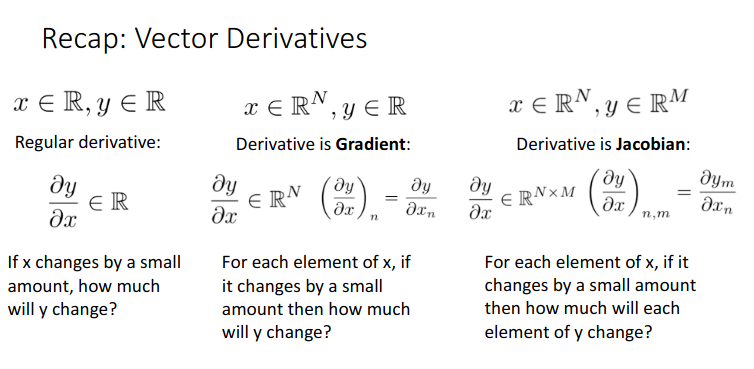

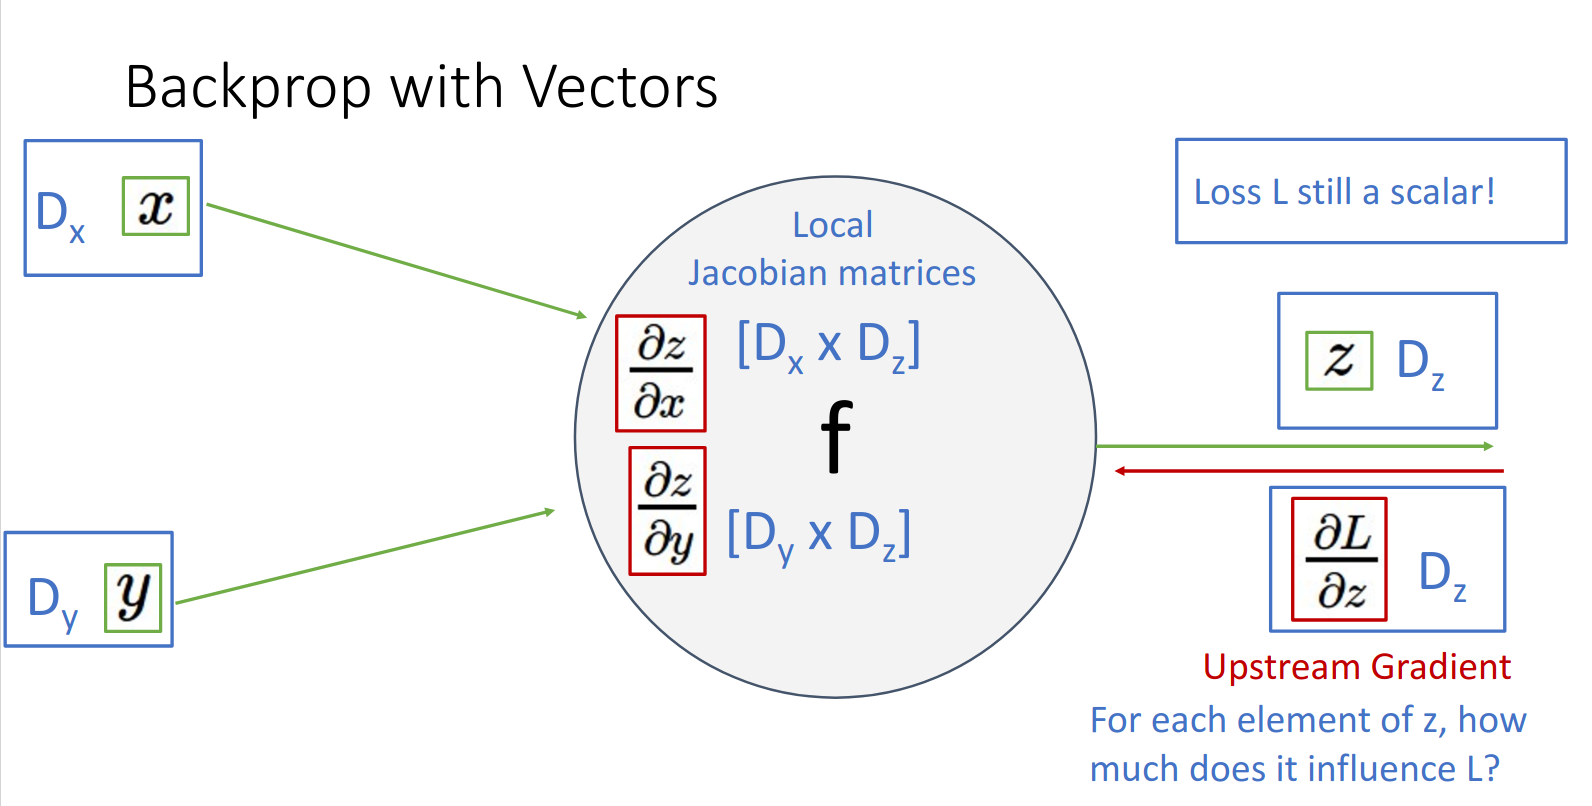

Источник: https://web.eecs.umich.edu/~justincj/slides/eecs498/498_FA2019_lecture06.pdf

### Вычисление градиентов в матричной форме

Рассмотрим простой случай $Y=XW$, тогда:

$$
\frac{ \partial{loss} }{\partial{X}} =  \frac{ \partial{loss} }{\partial{Y}}W^T
$$

$$
\frac{ \partial{loss} }{\partial{W}} = X^T\frac{ \partial{loss} }{\partial{Y}}
$$

Нужно заметить что в этом случае мы не рассматривали вариант когда $Y=XW+b$. Это можно расписать следующим образом.

$$
\frac{ \partial{loss} }{\partial{B}} = I^T\frac{ \partial{loss} }{\partial{Y}}
$$

Где $I$ это вектор из едениц. Другими словами мы просто можем взять сумму $\frac{ \partial{loss} }{\partial{Y}}$ элементов этой матрицы.

<br>

_*подсказка, в коде это будет выглядеть вот так input_grad.sum(0)_

<br>

<hr>

Подрбный вывод можно найти вот тут:

1. https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html

2. https://www.youtube.com/watch?v=dB-u77Y5a6A

In [ ]:
### YOUR TASK STARTS HERE ###

#Here you should implement by yourself MLP class and its constituents including forward and backward propagation methods

class Linear:
    def __init__(self, input_size, output_size):
        # Trainable parameters of the layer and their gradients
        self.thetas = np.random.randn(input_size, output_size) # the weight matrix of the layer (W)
        self.thetas_grads = np.empty_like(self.thetas) # gradient w.r.t. the weight matrix of the layer
        self.bias = np.random.randn(output_size) # bias terms of the layer (b)
        self.bias_grads = np.empty_like(self.bias) # gradient w.r.t. bias terms of the linear layer

    def forward(self, x):
        # keep x for backward computation
        self.x = x
        output = np.matmul(x, self.thetas) + self.bias
        return output

    def backward(self, input_grad, learning_rate):
        """
        Calculate and return gradient of the loss w.r.t. the input of linear layer given the input x and the gradient
        w.r.t output of linear layer. You should also calculate and update gradients of layer parameters.
        :param x: np.array, input tensor for linear layer;
        :param output_grad: np.array, grad tensor w.r.t output of linear layer;
        :return: np.array, grad w.r.t input of linear layer
        """

        ### BEGIN Solution
        # ... calculate grads
        # >>> your solution here <<<

        # Пример градиенты по второму слою
        # dloss/dout * dsoftmax/dh2 * O1
        # (F(x) - y)X.T

        self.thetas_grads = self.x.T.dot(input_grad)
        self.bias_grads = input_grad.sum(0)

        # Пример градиенты по второму слою / пробрасываем в первый слой
        # dloss/dout * dsoftmax/dh2 * dh2/dO1
        # dh2/dO1 = thetha

        output_grad = input_grad.dot(self.thetas.T)
        ### END Solution

        self.step(learning_rate)
        return output_grad

    def step(self, learning_rate):
        self.thetas -= self.thetas_grads * learning_rate
        self.bias -= self.bias_grads * learning_rate

class LogisticActivation:
    def __init__(self):
        # the layer has no parameters
        pass

    def sig(self, x):
        return 1/(1 + np.exp(-x))

    def forward(self, x):
        # keep o for backward computation
        self.o = self.sig(x)
        return self.o


    def backward(self,  input_grad, learning_rate):
        """
        Calculate and return the gradient of the loss w.r.t. the input
        of logistic non-linearity (given input x and the gradient
        w.r.t output of logistic non-linearity).

        :param x: np.array, input tensor for logistic non-linearity;
        :param output_grad: np.array, grad tensor w.r.t output of logistic non-linearity;
        :return: np.array, grad w.r.t input of logistic non-linearity

        """

        ### BEGIN Solution
        # >>> your solution here <<<

        # input_grad * 𝑠𝑖𝑔𝑚𝑜𝑖𝑑(ℎ1)(1−𝑠𝑖𝑔𝑚𝑜𝑖𝑑(ℎ1))

        output_grad = input_grad * self.o  * (1 - self.o )

        ### END Solution
        return output_grad


class MLP:
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.linear1 = Linear(input_size, hidden_layer_size)
        self.activation1 = LogisticActivation()
        self.linear2 = Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h1 = self.linear1.forward(x)
        h1a = self.activation1.forward(h1)
        out = self.linear2.forward(h1a)
        return out

    def backward(self, output_grad, learning_rate):
        """
        Calculate and return the gradient of the loss w.r.t. the input of MLP given the input and the gradient
        w.r.t output of MLP. You should also update gradients of paramerters of MLP layers.
        Hint - you should chain backward operations of modules you have already implemented. You may also
        need to calculate intermediate forward results.

        :param x: np.array, input tensor for MLP;
        :param output_grad: np.array, grad tensor w.r.t output of MLP;
        :return: np.array, grad w.r.t input of MLP
        """
        g1 = self.linear2.backward(output_grad, learning_rate)
        g2 = self.activation1.backward(g1, learning_rate)
        out = self.linear1.backward(g2, learning_rate)
        return  out


In [ ]:
### BEGIN Solution
def softmax_crossentropy_with_logits(logits, reference_answers):
    # >>> your solution here <<<

    m = reference_answers.shape[0]
    exps = np.exp(logits - np.max(logits)) # To make softmax numerical stable
    probs = exps / np.sum(exps)

    log_likelihood = -np.log(probs[range(m), reference_answers])
    loss = np.sum(log_likelihood) / m

    ### END Solution
    return loss

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    # >>> your solution here <<<

    m = reference_answers.shape[0]
    exps = np.exp(logits - np.max(logits)) # To make softmax numerical stable
    probs = exps / np.sum(exps)


    probs[range(m),reference_answers] -= 1
    grad = probs / m

    return grad

### END Solution

In [ ]:
np.random.seed(42)

mlp = MLP(input_size=input_size, hidden_layer_size=100, output_size=classes_n)

epochs_n = 100
learning_curve = [0] * epochs_n
test_curve = [0] * epochs_n

x_train = digits_train
x_test = digits_test
y_train = targets_train
y_test = targets_test

learning_rate = 1e-2

for epoch in range(epochs_n):

    y_pred = []

    for sample_i in range(train_size):
        x = x_train[sample_i].reshape((1, -1))
        target = np.array([y_train[sample_i]])
        logits = mlp.forward(x)

        ### BEGIN Solution
        # ... zero the gradients of the model
        # ... perform forward pass and compute the loss
        # ... compute the gradients w.r.t. the input of softmax layer
        # ... perform backward pass
        # ... and update the weights with weight -= grad * learning_rate

        loss = softmax_crossentropy_with_logits(logits, target)
        output_grad = grad_softmax_crossentropy_with_logits(logits, target)
        # >>> your solution here <<<

        mlp.backward(output_grad, learning_rate) # step is in backward
        y_pred.extend(logits.argmax(1))

    if epoch % 10 == 0:

        y_pred_test = []

        for sample_i in range(test_size):
            x = x_test[sample_i].reshape((1, -1))
            target = np.array([y_test[sample_i]])

            logits = mlp.forward(x)
            y_pred_test.extend(logits.argmax(1))

        print('Starting epoch {}'.format(epoch), \
              ', Loss : {:.3}'.format(loss), \
              ', Accuracy on train: {:.3}'.format(accuracy_score(y_train, y_pred)), \
              ', Accuracy on test: {:.3}'.format(accuracy_score(y_test, y_pred_test)) )

    ### END Solution

Starting epoch 0 , Loss : 2.71 , Accuracy on train: 0.103 , Accuracy on test: 0.0667
Starting epoch 10 , Loss : 2.15 , Accuracy on train: 0.625 , Accuracy on test: 0.649
Starting epoch 20 , Loss : 1.55 , Accuracy on train: 0.821 , Accuracy on test: 0.807
Starting epoch 30 , Loss : 1.07 , Accuracy on train: 0.875 , Accuracy on test: 0.871
Starting epoch 40 , Loss : 0.742 , Accuracy on train: 0.9 , Accuracy on test: 0.889
Starting epoch 50 , Loss : 0.534 , Accuracy on train: 0.911 , Accuracy on test: 0.904
Starting epoch 60 , Loss : 0.399 , Accuracy on train: 0.92 , Accuracy on test: 0.924
Starting epoch 70 , Loss : 0.308 , Accuracy on train: 0.927 , Accuracy on test: 0.931
Starting epoch 80 , Loss : 0.245 , Accuracy on train: 0.929 , Accuracy on test: 0.931
Starting epoch 90 , Loss : 0.198 , Accuracy on train: 0.936 , Accuracy on test: 0.933


In [ ]:
confusion_matrix(y_test, y_pred_test)

array([[37,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 39,  0,  0,  0,  0,  2,  0,  0,  2],
       [ 0,  2, 40,  1,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0, 42,  0,  0,  0,  1,  1,  1],
       [ 0,  0,  0,  0, 37,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  0,  0,  0,  2],
       [ 0,  1,  0,  0,  0,  0, 51,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 48,  0,  0],
       [ 0,  4,  1,  0,  0,  1,  0,  1, 41,  0],
       [ 0,  0,  0,  4,  0,  2,  0,  1,  1, 39]])

### Полезные ссылки:
1. https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html

2. https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b

3. https://web.eecs.umich.edu/~justincj/slides/eecs498/498_FA2019_lecture06.pdf

4. https://www.youtube.com/watch?v=dB-u77Y5a6A